### Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:10 (МСК)

### Переходим к практике

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd

Наши новости

In [3]:
news = pd.read_csv('materials.csv')
print(news.shape)
news.head()

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


Загрузим пользователей и списки последних прочитанных новостей

In [4]:
users = pd.read_csv('users_articles.csv')
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [5]:
# from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
# предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
# !pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [10]:
def clean_text(text):
    """
    очистка текста
    на выходе очищеный текст
    """
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub('-\s\r\n\|-\s\r\n|\r\n', '', str(text))

    text = re.sub('[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|', '', text)
    text = re.sub(r'\r\n\t|\n|\\s|\r\t|\\n', ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('nn', ' ', text)
    
    # tokens = list(tokenize(text))
    # words = [_.text for _ in tokens]
    # words = [w for w in words if w not in stopword_ru]
    
    # return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    """
    лемматизация
        [0] если зашел тип не 'str' делаем его 'str'
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    """

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
list(tokenize(news.iloc[0, 1][:100], ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [12]:
norm_text = news.iloc[:2, 1].apply(lambda x: clean_text(x), 1)
norm_text

0    заместитель председателяnправительства рфnсерг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [13]:
print(norm_text[0])

заместитель председателяnправительства рфnсергейnивановnизбран председателем советаnпбк цскаn как сообщаетnпрессслужбаnармейцев такое решение было единогласно принято на первом заседании совета клуба основной функцией этого органа будет обсуждение текущего состояния планирование и утверждение стратегии развития клуба на ближайшую перспективу в состав совета вошлиnгеоргий полтавченкоnполномочный представитель президента в центральном федеральном округеnалексей седовnгенералполковник начальник службы по защите конституционного строя и борьбе с терроризмомnфсб рф александр новакnзаместитель министра финансов рфnвячеслав полтавцевnзаместитель генерального директора руководитель блока по взаимодействию с органами власти социальной и корпоративной политикиnгмк норильский никель леонид исаковичnгенеральный директор ооо ук спортивные проектыnольга плешаковаnгенеральный директорnтрансаэро александр провоторовn генеральный директорnоао ростелекомn андрей лопатов эксигрок цска чемпион мира трехкр

In [14]:
' '.join(lemmatization(norm_text[0]))

'заместитель председатель правительство рф сергей иванов избрать председатель совет пбк цска прессслужба армеец решение единогласно принять первый заседание совет клуб основной функция орган обсуждение текущий состояние планирование утверждение стратегия развитие клуб близкий перспектива состав совет войти георгий полтавченко полномочный центральный федеральный округ алексей седов генералполковник начальник служба защита конституционный строй борьба терроризм фсб рф александр новак заместитель министр финансы рф вячеслав полтавец заместитель генеральный директор руководитель блок взаимодействие орган власть социальный корпоративный политика гмк норильский никель леонид исакович генеральный директор ооо ук спортивный проект ольга плешаков генеральный директор трансаэро александр провоторов генеральный директор оао ростелеком андрей лопат эксигрок цска чемпион мир трёхкратный чемпион европа баскетбол председатель правление банк клиентский андрей ватутин пбк цска'

In [15]:
%%time
# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 14.9 s, sys: 75.8 ms, total: 15 s
Wall time: 15 s


In [16]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 1min 41s, sys: 94.1 ms, total: 1min 41s
Wall time: 1min 41s


А теперь в 3 строчки обучим нашу модель

In [17]:
# сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [18]:
common_dictionary[10]

'взаимодействие'

In [19]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'прессслужба',
 59: 'принять',
 

In [20]:
common_dictionary.doc2bow(['баскетбол', 'баскетбол', 'наше', 'все'], allow_update=True)

[(5, 2), (140250, 1), (140251, 1)]

In [21]:
common_corpus[0][0]

(0, 2)

In [22]:
len(texts[0])

113

Все просто - это словарь наших слов

Запускаем обучение

In [23]:
n_topic = 20

In [24]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=n_topic, id2word=common_dictionary) #, passes=10)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [25]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.1599579),
 (6, 0.3786425),
 (11, 0.07172551),
 (13, 0.26200563),
 (18, 0.10729149)]

In [26]:
x = lda.show_topics(num_topics=n_topic, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Only Words 
for topic, words in topics_words:
    print(f'topic_{topic}: {" ".join(words)}')

topic_0: миссия треть опасаться стресс выстрел репутация тереза
topic_1: земля статья первый рост опубликовать университет новый
topic_2: проект млрд новый область рынок фонд украина
topic_3: пациент женщина болезнь хороший исследование египет жизнь
topic_4: дональд научный государство бомба автомобиль глава белорусский
topic_5: россия российский санкция сша закон правительство смерть
topic_6: поверхность рак товар вицепремьер фестиваль первый университет
topic_7: население операция экономика развитие экономический эксперт уровень
topic_8: гражданин ребёнок памятник жить народный вирус всё
topic_9: газ погибнуть взрыв северный инвестиция налог расследование
topic_10: ракета гражданин запуск блок фронт следствие кандидат
topic_11: экипаж восток медведев квартира предполагать флот рекомендовать
topic_12: конкурс диск индия норвежский дания победитель вечеринка
topic_13: научный исследование возраст день век сайт школа
topic_14: китай путин остров китайский японский иск япония
topic_15: р

In [27]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [28]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(3, 0.50095594), (6, 0.28954393), (13, 0.11405416), (15, 0.06765347)]

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [29]:
# text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(n_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [30]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(n_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id'] + [x for x in topic_matrix.columns if x != 'doc_id']]
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.000000,0.765169,0.012223,0.0,0.0,0.125921,0.0,0.0,...,0.0,0.000000,0.0,0.045145,0.0,0.044033,0.000000,0.000000,0.000000,0.0
1,4896,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.902964,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.073340,0.000000,0.000000,0.000000,0.0
2,4897,0.0,0.159969,0.000000,0.000000,0.0,0.0,0.378644,0.0,0.0,...,0.0,0.071726,0.0,0.262005,0.0,0.000000,0.000000,0.000000,0.107279,0.0
3,4898,0.0,0.095004,0.000000,0.106282,0.0,0.0,0.405665,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.382625,0.000000,0.000000,0.0
4,4899,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.779577,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.193929,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [31]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [32]:
doc_dict = dict(zip(
    topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(n_topic)]].values))

In [33]:
doc_dict[293622]

array([0.        , 0.06537495, 0.        , 0.07450774, 0.        ,
       0.11063647, 0.        , 0.07646186, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.28487724, 0.05558978,
       0.03515189, 0.20122141, 0.0517844 , 0.03575581, 0.        ])

In [34]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [35]:
get_user_embedding(user_articles_list, doc_dict)

array([0.        , 0.09557257, 0.09386793, 0.00222409, 0.00545305,
       0.13198479, 0.00889656, 0.03198268, 0.0046167 , 0.00468455,
       0.02740426, 0.00577289, 0.        , 0.02941861, 0.05447725,
       0.05555988, 0.38944672, 0.03418704, 0.00835318, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [36]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [37]:
' '.join(news[news['doc_id'] == 323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать барак 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [38]:
user_embeddings = pd.DataFrame(
    [i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict), 1)])
user_embeddings.columns = [f'topic_{i}' for i in range(n_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + [x for x in user_embeddings.columns if x != 'uid']]
user_embeddings.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.017624,0.184064,0.020003,0.064380,0.131370,0.039012,0.012744,0.080001,...,0.000000,0.000000,0.000000,0.126188,0.009265,0.009438,0.194224,0.008631,0.026072,0.0
1,u108690,0.000000,0.070192,0.127942,0.020046,0.017131,0.089423,0.037016,0.100523,0.039615,...,0.000000,0.002031,0.005855,0.022661,0.009937,0.081534,0.353554,0.003913,0.003744,0.0
2,u108339,0.002163,0.076510,0.098684,0.007302,0.012315,0.093935,0.012019,0.058157,0.008368,...,0.001880,0.018147,0.004081,0.027923,0.002162,0.090776,0.373688,0.044133,0.006644,0.0
3,u101138,0.000000,0.012068,0.029851,0.088648,0.010987,0.007738,0.214595,0.033045,0.116876,...,0.000000,0.000000,0.000000,0.111947,0.013006,0.000000,0.122519,0.004982,0.194640,0.0
4,u108248,0.000000,0.148048,0.053808,0.030677,0.013206,0.092942,0.054825,0.043084,0.045066,...,0.002715,0.010790,0.000000,0.071884,0.027810,0.019000,0.339652,0.001851,0.014375,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [39]:
target = pd.read_csv('users_churn.csv')
target.head()

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [40]:
x = pd.merge(user_embeddings, target, 'left')
x.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.017624,0.184064,0.020003,0.064380,0.131370,0.039012,0.012744,0.080001,...,0.000000,0.000000,0.126188,0.009265,0.009438,0.194224,0.008631,0.026072,0.0,0
1,u108690,0.000000,0.070192,0.127942,0.020046,0.017131,0.089423,0.037016,0.100523,0.039615,...,0.002031,0.005855,0.022661,0.009937,0.081534,0.353554,0.003913,0.003744,0.0,1
2,u108339,0.002163,0.076510,0.098684,0.007302,0.012315,0.093935,0.012019,0.058157,0.008368,...,0.018147,0.004081,0.027923,0.002162,0.090776,0.373688,0.044133,0.006644,0.0,1
3,u101138,0.000000,0.012068,0.029851,0.088648,0.010987,0.007738,0.214595,0.033045,0.116876,...,0.000000,0.000000,0.111947,0.013006,0.000000,0.122519,0.004982,0.194640,0.0,0
4,u108248,0.000000,0.148048,0.053808,0.030677,0.013206,0.092942,0.054825,0.043084,0.045066,...,0.010790,0.000000,0.071884,0.027810,0.019000,0.339652,0.001851,0.014375,0.0,1


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# разделим данные на train/test
x_train, x_test, y_train, y_test = train_test_split(x[[f'topic_{i}' for i in range(n_topic)]], 
                                                    x['churn'], random_state=42)

In [43]:
clf = RandomForestClassifier()
# обучим наш пайплайн
clf.fit(x_train, y_train)

RandomForestClassifier()

In [44]:
pred = clf.predict_proba(x_test)
pred[:10]

array([[1.  , 0.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.97, 0.03],
       [0.95, 0.05],
       [0.99, 0.01],
       [0.92, 0.08],
       [0.26, 0.74],
       [0.98, 0.02]])

In [45]:
preds = clf.predict(x_test)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [46]:
# наши прогнозы для тестовой выборки
preds = clf.predict_proba(x_test)[:, 1]
preds[:10]

array([0.  , 0.02, 0.  , 0.05, 0.03, 0.05, 0.01, 0.08, 0.74, 0.02])

In [47]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix

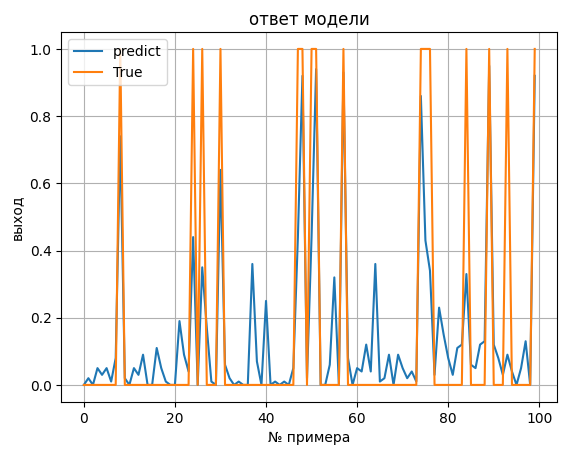

In [48]:
plt.plot(preds[:100], label='predict')
plt.plot(y_test.values[:100], label='True')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

### Рассчитаем Precision, Recall, F_score

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [50]:
precision[:10]

array([0.1265    , 0.1585213 , 0.1796875 , 0.20386785, 0.22340426,
       0.24753452, 0.26587729, 0.29058824, 0.31612903, 0.33841886])

In [51]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:0.3f}, ' 
      f'Precision={precision[ix]:0.3f}, Recall={recall[ix]:0.3f}')

Best Threshold=0.33, F-Score=0.778, Precision=0.786, Recall=0.771


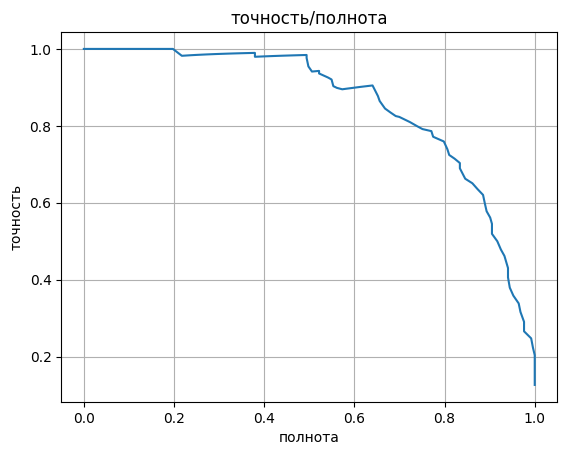

In [52]:
plt.plot(recall, precision)
plt.title('точность/полнота')
plt.xlabel('полнота')
plt.ylabel('точность')
plt.grid('On')
plt.show()

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1697   50]
 [  63  190]]


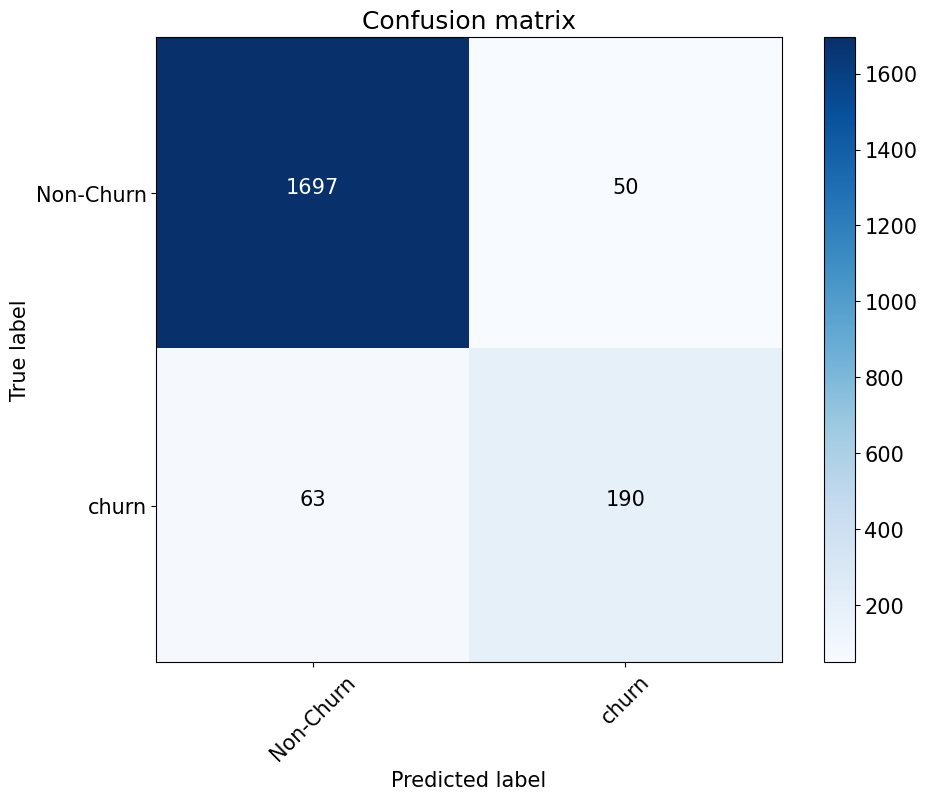

In [54]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig('conf_matrix.png')
plt.show()

In [55]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9627390602976079

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

### 02

In [56]:
def get_user_embedding_m(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [57]:
%%time
user_embeddings_m = pd.DataFrame(
    [i for i in users['articles'].apply(lambda x: get_user_embedding_m(x, doc_dict))])
user_embeddings_m.columns = [f'topic_{i}' for i in range(n_topic)]
user_embeddings_m['uid'] = users['uid'].values
user_embeddings_m = user_embeddings_m[['uid'] + 
                                      [x for x in user_embeddings_m.columns if x != 'uid']]
user_embeddings_m.head()

CPU times: user 341 ms, sys: 733 µs, total: 342 ms
Wall time: 342 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.000000,0.047757,0.005486,0.030149,0.097057,0.000000,0.000000,0.015745,...,0.0,0.0,0.0,0.108816,0.0,0.000000,0.158312,0.000000,0.000000,0.0
1,u108690,0.0,0.061556,0.121550,0.000000,0.000000,0.077607,0.011868,0.097735,0.034265,...,0.0,0.0,0.0,0.000000,0.0,0.030721,0.317409,0.000000,0.000000,0.0
2,u108339,0.0,0.053121,0.102172,0.000000,0.006857,0.073774,0.006175,0.019882,0.000000,...,0.0,0.0,0.0,0.012644,0.0,0.041160,0.405848,0.021193,0.000000,0.0
3,u101138,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.102177,0.018349,0.059270,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.042391,0.000000,0.039532,0.0
4,u108248,0.0,0.087313,0.030552,0.000000,0.000000,0.051934,0.037452,0.023563,0.031859,...,0.0,0.0,0.0,0.040891,0.0,0.009371,0.355139,0.000000,0.000000,0.0


In [58]:
x_m = pd.merge(user_embeddings_m, target, 'left')
x_m.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.000000,0.047757,0.005486,0.030149,0.097057,0.000000,0.000000,0.015745,...,0.0,0.0,0.108816,0.0,0.000000,0.158312,0.000000,0.000000,0.0,0
1,u108690,0.0,0.061556,0.121550,0.000000,0.000000,0.077607,0.011868,0.097735,0.034265,...,0.0,0.0,0.000000,0.0,0.030721,0.317409,0.000000,0.000000,0.0,1
2,u108339,0.0,0.053121,0.102172,0.000000,0.006857,0.073774,0.006175,0.019882,0.000000,...,0.0,0.0,0.012644,0.0,0.041160,0.405848,0.021193,0.000000,0.0,1
3,u101138,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.102177,0.018349,0.059270,...,0.0,0.0,0.000000,0.0,0.000000,0.042391,0.000000,0.039532,0.0,0
4,u108248,0.0,0.087313,0.030552,0.000000,0.000000,0.051934,0.037452,0.023563,0.031859,...,0.0,0.0,0.040891,0.0,0.009371,0.355139,0.000000,0.000000,0.0,1


In [59]:
xm_train, xm_test, ym_train, ym_test = train_test_split(
    x_m[[f'topic_{i}' for i in range(n_topic)]], x_m['churn'], random_state=42)

In [60]:
clf_m = RandomForestClassifier()
clf_m.fit(xm_train, ym_train)

RandomForestClassifier()

In [61]:
preds_m = clf_m.predict_proba(xm_test)[:, 1]
preds_m[:10]

array([0.  , 0.  , 0.  , 0.02, 0.05, 0.  , 0.  , 0.  , 0.74, 0.  ])

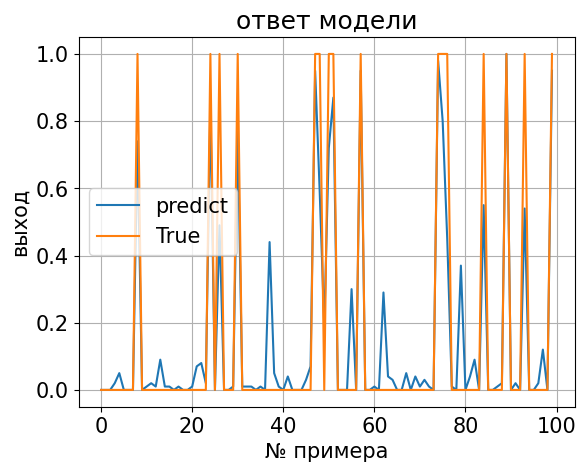

In [62]:
plt.plot(preds_m[:100], label='predict')
plt.plot(ym_test.values[:100], label='True')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [63]:
precision_m, recall_m, thresholds_m = precision_recall_curve(ym_test, preds_m)
fscore_m = (2 * precision_m * recall_m) / (precision_m + recall_m)
ix_m = np.argmax(fscore_m)
print(f'Best Threshold={thresholds_m[ix_m]}, F-Score={fscore_m[ix_m]:0.3f}, ' 
      f'Precision={precision_m[ix_m]:0.3f}, Recall={recall_m[ix_m]:0.3f}')

Best Threshold=0.42, F-Score=0.914, Precision=0.923, Recall=0.905


Confusion matrix, without normalization
[[1729   18]
 [  25  228]]


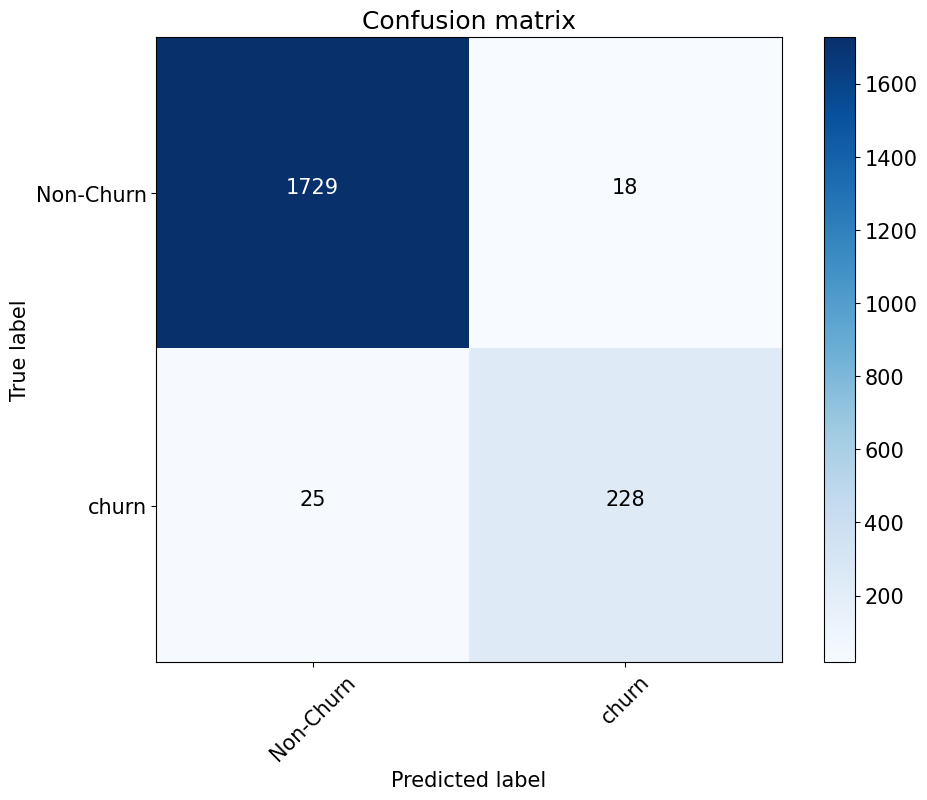

In [64]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_m = confusion_matrix(ym_test, preds_m > thresholds_m[ix_m])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_m, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig('conf_matrix.png')
plt.show()

In [65]:
roc_auc_m = roc_auc_score(ym_test, preds_m)
roc_auc_m

0.9947351869155706

### 03

In [66]:
def get_user_embedding_x(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [67]:
%%time
user_embeddings_x = pd.DataFrame(
    [i for i in users['articles'].apply(lambda x: get_user_embedding_x(x, doc_dict))])
user_embeddings_x.columns = [f'topic_{i}' for i in range(n_topic)]
user_embeddings_x['uid'] = users['uid'].values
user_embeddings_x = user_embeddings_x[['uid'] + 
                                      [x for x in user_embeddings_x.columns if x != 'uid']]
user_embeddings_x.head()

CPU times: user 357 ms, sys: 4.44 ms, total: 361 ms
Wall time: 361 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.065375,0.518482,0.074508,0.253191,0.304435,0.191353,0.076462,0.255433,...,0.000000,0.000000,0.000000,0.284877,0.055590,0.035152,0.428172,0.051784,0.120674,0.0
1,u108690,0.000000,0.154262,0.308463,0.084447,0.077137,0.213711,0.170880,0.279632,0.090572,...,0.000000,0.012188,0.035131,0.109573,0.046988,0.244574,0.566048,0.012420,0.022467,0.0
2,u108339,0.012976,0.186401,0.188642,0.032612,0.044429,0.209557,0.030725,0.258531,0.030840,...,0.011280,0.075768,0.024485,0.095044,0.012969,0.302393,0.468462,0.173771,0.027664,0.0
3,u101138,0.000000,0.072408,0.154037,0.496656,0.065923,0.046427,0.784462,0.106968,0.387828,...,0.000000,0.000000,0.000000,0.657644,0.055525,0.000000,0.412300,0.029889,0.794277,0.0
4,u108248,0.000000,0.508088,0.165834,0.173193,0.041606,0.295364,0.197824,0.153204,0.137612,...,0.016291,0.040043,0.000000,0.176210,0.166860,0.072828,0.388828,0.011103,0.086248,0.0


In [68]:
xx = pd.merge(user_embeddings_x, target, 'left')
xx.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.065375,0.518482,0.074508,0.253191,0.304435,0.191353,0.076462,0.255433,...,0.000000,0.000000,0.284877,0.055590,0.035152,0.428172,0.051784,0.120674,0.0,0
1,u108690,0.000000,0.154262,0.308463,0.084447,0.077137,0.213711,0.170880,0.279632,0.090572,...,0.012188,0.035131,0.109573,0.046988,0.244574,0.566048,0.012420,0.022467,0.0,1
2,u108339,0.012976,0.186401,0.188642,0.032612,0.044429,0.209557,0.030725,0.258531,0.030840,...,0.075768,0.024485,0.095044,0.012969,0.302393,0.468462,0.173771,0.027664,0.0,1
3,u101138,0.000000,0.072408,0.154037,0.496656,0.065923,0.046427,0.784462,0.106968,0.387828,...,0.000000,0.000000,0.657644,0.055525,0.000000,0.412300,0.029889,0.794277,0.0,0
4,u108248,0.000000,0.508088,0.165834,0.173193,0.041606,0.295364,0.197824,0.153204,0.137612,...,0.040043,0.000000,0.176210,0.166860,0.072828,0.388828,0.011103,0.086248,0.0,1


In [69]:
xx_train, xx_test, yx_train, yx_test = train_test_split(
    xx[[f'topic_{i}' for i in range(n_topic)]], xx['churn'], random_state=42)

In [70]:
clf_x = RandomForestClassifier()
clf_x.fit(xx_train, yx_train)

RandomForestClassifier()

In [71]:
preds_x = clf_x.predict_proba(xx_test)[:, 1]
preds_x[:10]

array([0.  , 0.01, 0.02, 0.09, 0.14, 0.  , 0.  , 0.1 , 0.61, 0.01])

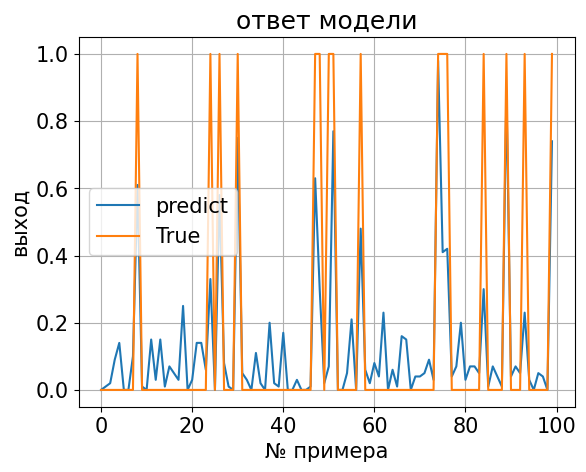

In [72]:
plt.plot(preds_x[:100], label='predict')
plt.plot(yx_test.values[:100], label='True')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [73]:
precision_x, recall_x, thresholds_x = precision_recall_curve(yx_test, preds_x)
fscore_x = (2 * precision_x * recall_x) / (precision_x + recall_x)
ix_x = np.argmax(fscore_x)
print(f'Best Threshold={thresholds_x[ix_x]}, F-Score={fscore_x[ix_x]:0.3f}, ' 
      f'Precision={precision_x[ix_x]:0.3f}, Recall={recall_x[ix_x]:0.3f}')

Best Threshold=0.32, F-Score=0.840, Precision=0.860, Recall=0.822


Confusion matrix, without normalization
[[1718   29]
 [  49  204]]


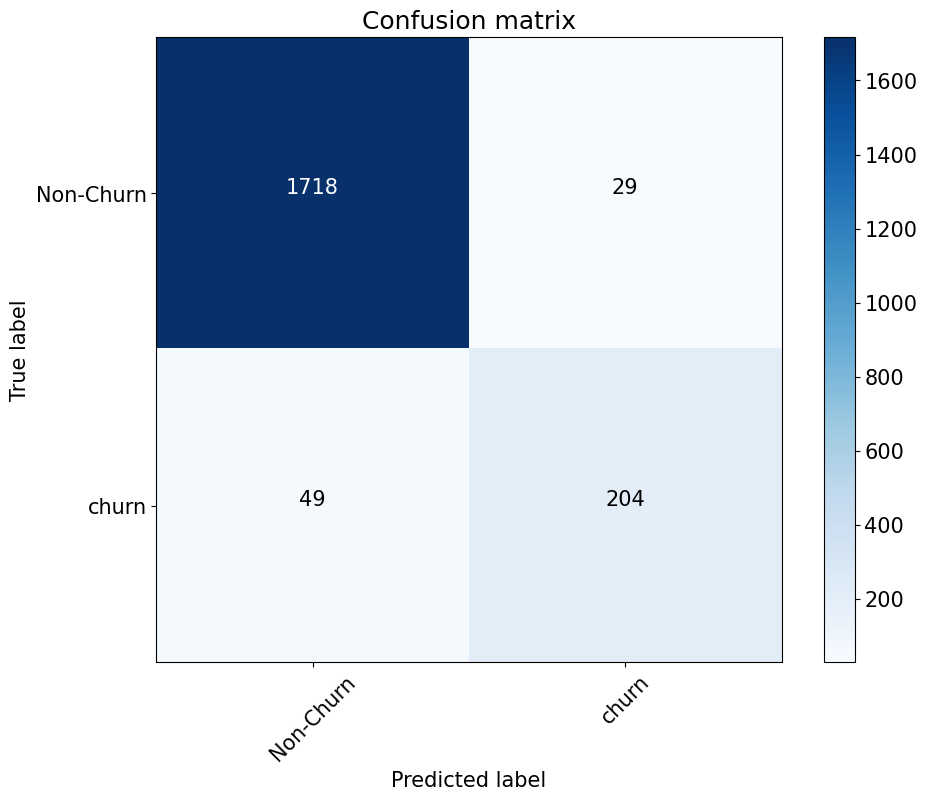

In [74]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_x = confusion_matrix(yx_test, preds_x > thresholds_x[ix_x])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_x, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig('conf_matrix.png')
plt.show()

In [75]:
roc_auc_x = roc_auc_score(yx_test, preds_x)
roc_auc_x

0.9828605107343814

### 04

In [76]:
from gensim.models import LdaModel, TfidfModel

In [77]:
tfidf_model = TfidfModel(common_corpus)
common_corpus_tfidf = [tfidf_model[doc] for doc in common_corpus]

In [78]:
lda_tfidf = LdaModel(common_corpus_tfidf, num_topics=n_topic, id2word=common_dictionary)

In [79]:
def get_lda_vector_tfidf(text):
    unseen_doc = tfidf_model[common_dictionary.doc2bow(text)]
    lda_tuple = lda_tfidf[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(n_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [80]:
topic_matrix_tfidf = pd.DataFrame([get_lda_vector_tfidf(text) for text in news['title'].values])
topic_matrix_tfidf.columns = [f'topic_{i}' for i in range(n_topic)]
topic_matrix_tfidf['doc_id'] = news['doc_id'].values
topic_matrix_tfidf = topic_matrix_tfidf[
    ['doc_id'] + [x for x in topic_matrix_tfidf.columns if x != 'doc_id']]
doc_dict_tfidf = dict(zip(topic_matrix_tfidf['doc_id'].values, 
                          topic_matrix_tfidf[[f'topic_{i}' for i in range(n_topic)]].values))

In [81]:
%%time
user_embeddings_f = pd.DataFrame(
    [i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict_tfidf))])
user_embeddings_f.columns = [f'topic_{i}' for i in range(n_topic)]
user_embeddings_f['uid'] = users['uid'].values
user_embeddings_f = user_embeddings_f[['uid'] + 
                                      [x for x in user_embeddings_f.columns if x != 'uid']]
user_embeddings_f.head()

CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 203 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.035106,0.017208,0.045601,0.012061,0.012061,0.054362,0.012061,0.017406,0.012061,...,0.012061,0.407481,0.090611,0.012061,0.012061,0.016178,0.018009,0.096537,0.018169,0.073006
1,u108690,0.006141,0.000000,0.006128,0.000000,0.000000,0.010914,0.000000,0.000000,0.000000,...,0.000000,0.498883,0.150411,0.000000,0.000000,0.006653,0.071845,0.049940,0.041987,0.032417
2,u108339,0.019891,0.001832,0.047721,0.001832,0.001832,0.028850,0.001832,0.001832,0.006534,...,0.010980,0.465927,0.135898,0.001832,0.001832,0.024247,0.046901,0.065333,0.031947,0.019198
3,u101138,0.027868,0.017047,0.063662,0.005644,0.005644,0.005644,0.005644,0.005644,0.005644,...,0.005644,0.574643,0.113332,0.005644,0.005644,0.005644,0.022342,0.016330,0.005644,0.028350
4,u108248,0.014301,0.008512,0.061808,0.008512,0.008512,0.008512,0.008512,0.008512,0.014748,...,0.018126,0.459133,0.116847,0.008512,0.008512,0.008512,0.047549,0.081050,0.025499,0.036399


In [82]:
xf = pd.merge(user_embeddings_f, target, 'left')
xf.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.035106,0.017208,0.045601,0.012061,0.012061,0.054362,0.012061,0.017406,0.012061,...,0.407481,0.090611,0.012061,0.012061,0.016178,0.018009,0.096537,0.018169,0.073006,0
1,u108690,0.006141,0.000000,0.006128,0.000000,0.000000,0.010914,0.000000,0.000000,0.000000,...,0.498883,0.150411,0.000000,0.000000,0.006653,0.071845,0.049940,0.041987,0.032417,1
2,u108339,0.019891,0.001832,0.047721,0.001832,0.001832,0.028850,0.001832,0.001832,0.006534,...,0.465927,0.135898,0.001832,0.001832,0.024247,0.046901,0.065333,0.031947,0.019198,1
3,u101138,0.027868,0.017047,0.063662,0.005644,0.005644,0.005644,0.005644,0.005644,0.005644,...,0.574643,0.113332,0.005644,0.005644,0.005644,0.022342,0.016330,0.005644,0.028350,0
4,u108248,0.014301,0.008512,0.061808,0.008512,0.008512,0.008512,0.008512,0.008512,0.014748,...,0.459133,0.116847,0.008512,0.008512,0.008512,0.047549,0.081050,0.025499,0.036399,1


In [83]:
xf_train, xf_test, yf_train, yf_test = train_test_split(
    xf[[f'topic_{i}' for i in range(n_topic)]], xf['churn'], random_state=42)

In [84]:
clf_f = RandomForestClassifier()
clf_f.fit(xf_train, yf_train)

RandomForestClassifier()

In [85]:
preds_f = clf_f.predict_proba(xf_test)[:, 1]
preds_f[:10]

array([0.  , 0.  , 0.02, 0.  , 0.  , 0.02, 0.  , 0.  , 1.  , 0.  ])

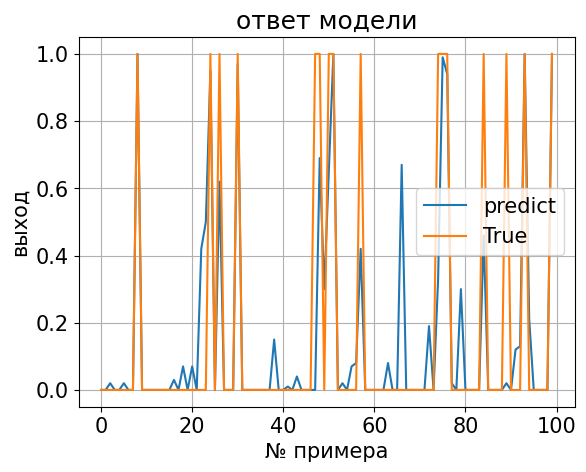

In [86]:
plt.plot(preds_f[:100], label='predict')
plt.plot(yf_test.values[:100], label='True')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [87]:
precision_f, recall_f, thresholds_f = precision_recall_curve(yf_test, preds_f)
fscore_f = (2 * precision_f * recall_f) / (precision_f + recall_f)
ix_f = np.argmax(fscore_f)
print(f'Best Threshold={thresholds_f[ix_f]}, F-Score={fscore_f[ix_f]:0.3f}, ' 
      f'Precision={precision_f[ix_f]:0.3f}, Recall={recall_f[ix_f]:0.3f}')

Best Threshold=0.34, F-Score=0.886, Precision=0.882, Recall=0.889


Confusion matrix, without normalization
[[1717   30]
 [  30  223]]


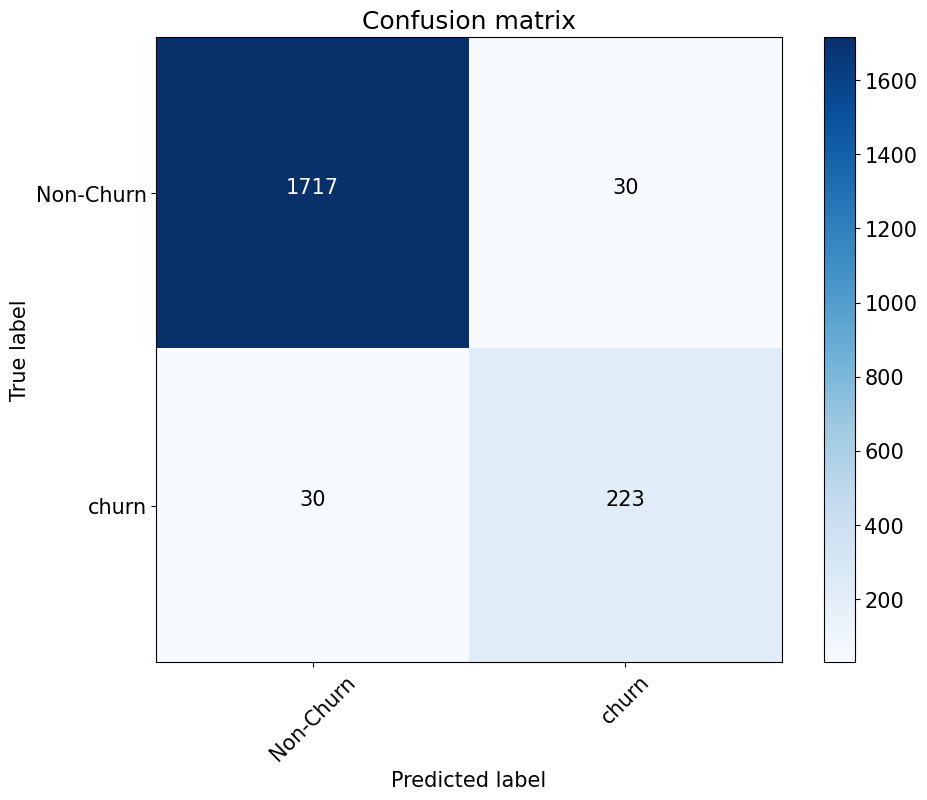

In [88]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_f = confusion_matrix(yf_test, preds_f > thresholds_f[ix_f])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_f, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig('conf_matrix.png')
plt.show()

In [89]:
roc_auc_f = roc_auc_score(yf_test, preds_f)
roc_auc_f

0.9797529813955488

In [90]:
metrics = pd.DataFrame({
    'methods': ['mean', 'median', 'max', 'tfidf'],
    'roc_auc': [roc_auc, roc_auc_m, roc_auc_x, roc_auc_f],
    'precision': [precision[ix], precision_m[ix_m], precision_x[ix_x], precision_f[ix_f]],
    'recall': [recall[ix], recall_m[ix_m], recall_x[ix_x], recall_f[ix_f]],
    'f_score': [fscore[ix], fscore_m[ix_m], fscore_x[ix_x], fscore_f[ix_f]]})
metrics

,methods,roc_auc,precision,recall,f_score
0,mean,0.962739,0.786290,0.770751,0.778443
1,median,0.994735,0.923387,0.905138,0.914172
2,max,0.982861,0.859504,0.822134,0.840404
3,tfidf,0.979753,0.882353,0.889328,0.885827


### 06

Самые лучшие результаты показал эмбеддинг по медиане. Возможно, это связано с тем, что медиана устойчива к выбросам и обладает более высокой точностью для обработки естественного языка. Если слово встречается слишком часто или слишком редко - оно оказывается одинаково бесполезно для выборки.
"Взвешенные" слова тоже отработали очень хорошо, и нам показалось, что если запустить этот алгоритм не по среднему арифметическому, а по медиане, мы получим еще лучшие результаты. Но это так не работает. Два алгоритма, по отдельности дающие высокие результаты, совместно могут дать низкие (в целом, они отработали хорошо, но хуже, чем все прочие представленные модели, поэтому мы не стали включать их в работу).